In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# data = pd.read_csv('./kaggle/cybersecurity_intrusion_data.csv')
data = pd.read_csv('./dataset/cybersecurity_intrusion_data.csv')
data.head()

2025-04-04 12:35:14.037302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 12:35:14.045953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 12:35:14.152446: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 12:35:14.290570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743762914.409557  997211 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743762914.44

,timestamp,hour,day_of_week,network_packet_size,is_attack,attack_type,connection_count,protocol,packet_per_minute,protocol_code
0,2025-03-01 00:00:00,0,5,343.423664,0,NaN,10,ICMP,34.342366,2
1,2025-03-01 00:01:00,0,5,271.015446,0,NaN,15,HTTP,18.067696,3
2,2025-03-01 00:02:00,0,5,364.213128,0,NaN,11,TCP,33.110284,0
3,2025-03-01 00:03:00,0,5,413.567874,0,NaN,15,UDP,27.571192,1
4,2025-03-01 00:04:00,0,5,275.529488,0,NaN,10,TCP,27.552949,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            20160 non-null  object 
 1   hour                 20160 non-null  int64  
 2   day_of_week          20160 non-null  int64  
 3   network_packet_size  20160 non-null  float64
 4   is_attack            20160 non-null  int64  
 5   attack_type          725 non-null    object 
 6   connection_count     20160 non-null  int64  
 7   protocol             20160 non-null  object 
 8   packet_per_minute    20160 non-null  float64
 9   protocol_code        20160 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 1.5+ MB


In [3]:
data.describe()

/home/user/3course/neural-network/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,hour,day_of_week,network_packet_size,is_attack,connection_count,packet_per_minute,protocol_code
count,20160.000000,20160.00000,20160.000000,20160.000000,20160.000000,2.016000e+04,20160.000000
mean,11.500000,3.00000,496.799581,0.035962,19.883829,inf,1.253175
std,6.922358,2.00005,337.973227,0.186201,17.376700,NaN,1.374904
min,0.000000,0.00000,10.000000,0.000000,0.000000,9.744467e+00,0.000000
25%,5.750000,1.00000,238.933048,0.000000,8.000000,2.019154e+01,0.000000
50%,11.500000,3.00000,458.514295,0.000000,15.000000,2.999779e+01,1.000000
75%,17.250000,5.00000,692.738058,0.000000,25.000000,3.983812e+01,3.000000
max,23.000000,6.00000,3634.937925,1.000000,251.000000,inf,4.000000


In [4]:
data.isna().sum()

timestamp                  0
hour                       0
day_of_week                0
network_packet_size        0
is_attack                  0
attack_type            19435
connection_count           0
protocol                   0
packet_per_minute          0
protocol_code              0
dtype: int64

In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
# sns.countplot(x="attack_detected",data=data,palette="Blues")
# plt.title("Total Attacks")
# plt.show()

In [7]:
packet_size_data = data['network_packet_size'].values

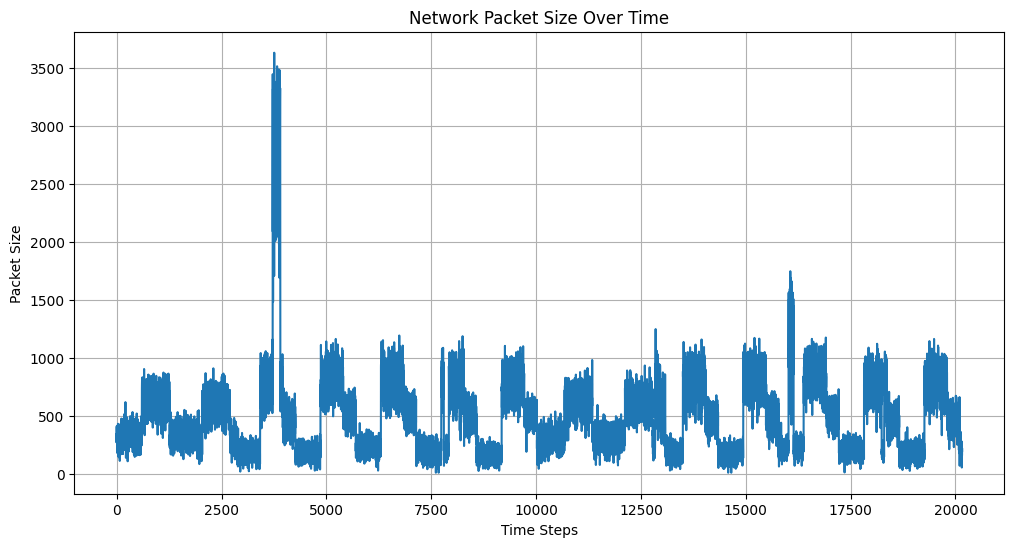

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(packet_size_data)
plt.title('Network Packet Size Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Packet Size')
plt.grid(True)
plt.show()

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
packet_size_scaled = scaler.fit_transform(packet_size_data.reshape(-1, 1))

time_steps = 500 

# print(len(packet_size_scaled))
sequence_length = len(packet_size_scaled) - time_steps
X = np.zeros((sequence_length, time_steps))
y = np.zeros((sequence_length,))

for i in range(sequence_length):
    X[i] = packet_size_scaled[i:i+time_steps, 0]
    y[i] = packet_size_scaled[i+time_steps, 0]

In [10]:
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (15728, 500, 1), y_train: (15728,)
X_test: (3932, 500, 1), y_test: (3932,)


In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

2025-04-04 12:35:17.143428: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/user/3course/neural-network/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, y_train, 
    epochs=5, 
    batch_size=32, 
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 87s 192ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 2/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 87s 197ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 89s 202ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 208ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 88s 199ms/step - loss: 0.0012 - val_loss: 0.0015


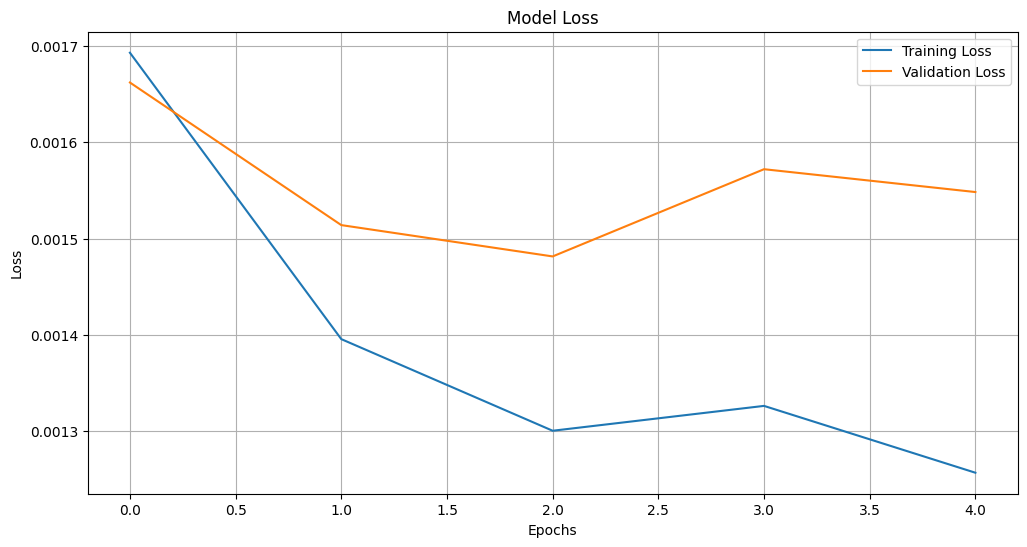

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

492/492 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step


In [15]:

train_plot = np.empty_like(packet_size_scaled)
train_plot[:] = np.nan
train_plot[time_steps:len(train_predict)+time_steps, :] = train_predict

test_plot = np.empty_like(packet_size_scaled)
test_plot[:] = np.nan

available_space = len(packet_size_scaled) - (len(train_predict) + (time_steps*2))
test_plot[len(train_predict)+(time_steps*2):len(packet_size_scaled), :] = test_predict[:available_space, :]

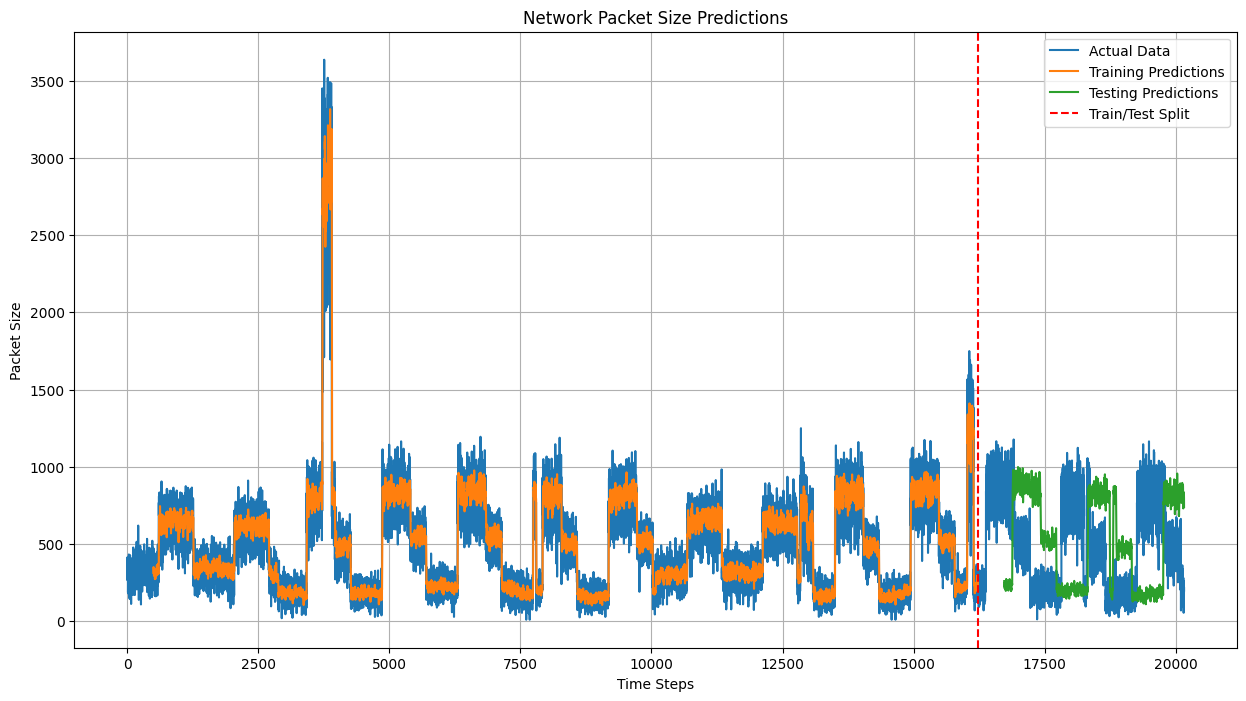

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(scaler.inverse_transform(packet_size_scaled), label='Actual Data')
plt.plot(train_plot, label='Training Predictions')
plt.plot(test_plot, label='Testing Predictions')
plt.axvline(x=train_size + time_steps, color='r', linestyle='--', label='Train/Test Split')
plt.title('Network Packet Size Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Packet Size')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
test_result = []
for i in range(len(y_test_inv)):
    test_result.append(abs(y_test_inv[i][0] - test_predict[i][0]))
test_result = np.array(test_result)


Anomaly threshold: 227.08588721302124
Number of anomalies detected: 201


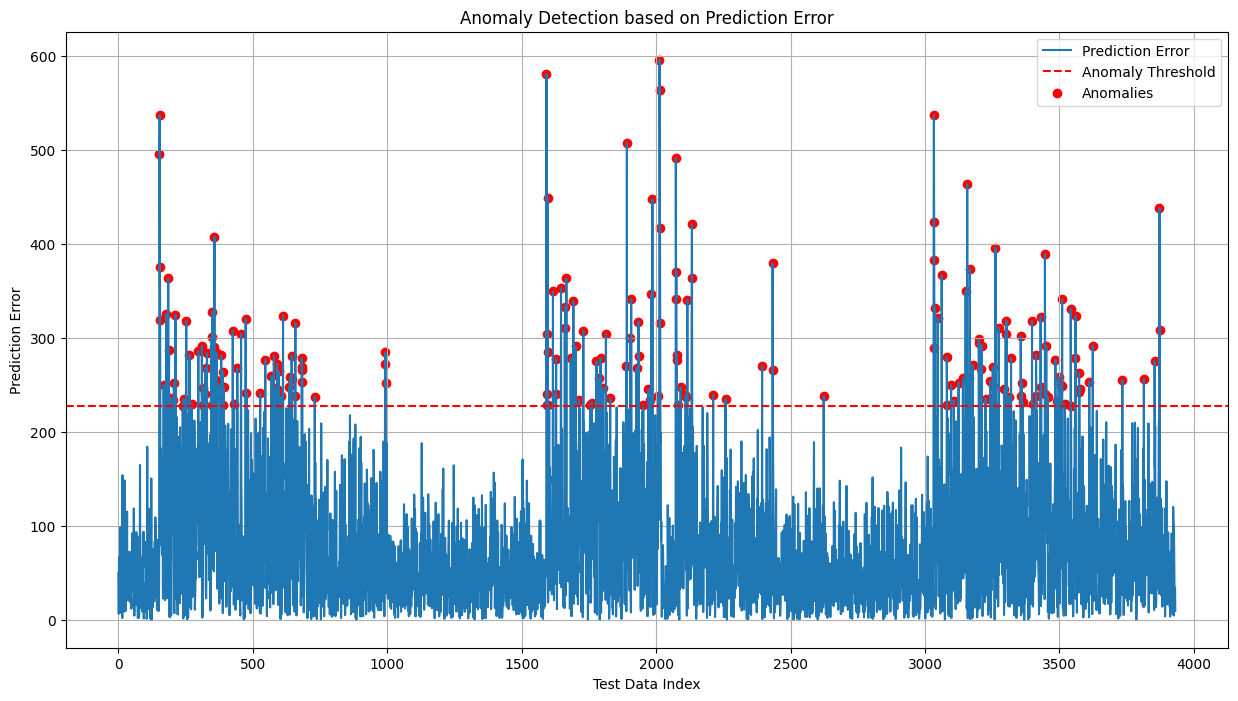

In [18]:
#  Define threshold for anomaly detection (e.g., errors > mean + 2*std)
threshold = np.mean(test_result) + 2 * np.std(test_result)
print(f"Anomaly threshold: {threshold}")

# Identify anomalies
anomalies = test_result > threshold
anomaly_indices = np.where(anomalies)[0]
print(f"Number of anomalies detected: {len(anomaly_indices)}")

# Plot anomalies
plt.figure(figsize=(15, 8))
plt.plot(test_result, label='Prediction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(anomaly_indices, test_result[anomaly_indices], color='red', label='Anomalies')
plt.title('Anomaly Detection based on Prediction Error')
plt.xlabel('Test Data Index')
plt.ylabel('Prediction Error')
plt.legend()
plt.grid(True)
plt.show()

In [19]:

pkl_filename = "lstm_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [20]:
test_rmse = root_mean_squared_error(y_test, test_predict)
test_rmse

592.6934549330412

In [21]:


# # Evaluate complex model
# test_predict_complex = model_complex.predict(X_test)
# test_predict_complex = scaler.inverse_transform(test_predict_complex)
# test_rmse_complex = np.sqrt(mean_squared_error(y_test_inv, test_predict_complex))
# print(f"Complex Model Test RMSE: {test_rmse_complex}")

# # 8.2 Try different window sizes
# time_steps_options = [30, 90, 120]
# results = []

# for ts in time_steps_options:
#     print(f"\nTrying window size: {ts}")
#     X_ts, y_ts = create_sequences(packet_size_scaled, ts)
#     X_ts = X_ts.reshape(X_ts.shape[0], X_ts.shape[1], 1)
    
#     train_size_ts = int(len(X_ts) * 0.8)
#     X_train_ts, X_test_ts = X_ts[:train_size_ts], X_ts[train_size_ts:]
#     y_train_ts, y_test_ts = y_ts[:train_size_ts], y_ts[train_size_ts:]
    
#     model_ts = Sequential([
#         LSTM(50, return_sequences=True, input_shape=(ts, 1)),
#         Dropout(0.2),
#         LSTM(50, return_sequences=False),
#         Dropout(0.2),
#         Dense(1)
#     ])
    
#     model_ts.compile(optimizer='adam', loss='mean_squared_error')
#     model_ts.fit(X_train_ts, y_train_ts, epochs=15, batch_size=32, verbose=0)
    
#     test_predict_ts = model_ts.predict(X_test_ts)
#     test_predict_ts = scaler.inverse_transform(test_predict_ts)
#     y_test_ts_inv = scaler.inverse_transform(y_test_ts.reshape(-1, 1))
#     test_rmse_ts = np.sqrt(mean_squared_error(y_test_ts_inv, test_predict_ts))
#     print(f"Window size {ts} - Test RMSE: {test_rmse_ts}")
#     results.append((ts, test_rmse_ts))

# # Plot results of window size experiments
# plt.figure(figsize=(10, 6))
# window_sizes = [time_steps] + [r[0] for r in results]
# rmse_values = [test_rmse] + [r[1] for r in results]
# plt.plot(window_sizes, rmse_values, marker='o')
# plt.title('RMSE vs Window Size')
# plt.xlabel('Window Size')
# plt.ylabel('Test RMSE')
# plt.grid(True)
# plt.show()

# # 9. Conclusion
# print("\n=== Conclusion ===")
# print("This notebook demonstrates LSTM-based time series analysis on network packet size data")
# print("The initial model achieved a test RMSE of:", test_rmse)
# print("The complex model achieved a test RMSE of:", test_rmse_complex)
# print("Best window size based on experiments:", min(results, key=lambda x: x[1])[0])
# print("Potential anomalies detected:", len(anomaly_indices))

In [22]:
# data=data.drop(["session_id","encryption_used"],axis=1)